## Импорт необходимых модулей и определение констант

In [157]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import shutil
from skimage.io import imread
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_predict, cross_validate

from sklearn.model_selection import learning_curve
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [151]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
SEED = 21
np.random.seed(SEED)
IMAGE_PATH = "../data/Raw/"


## Загрузка набора данных и предварительный анализ

### Функции отрисовки

Отрисовка нескольких изображений по пути файла

In [31]:
def draw_pictures(img_df):
    n = len(img_df)
    cols = 5
    if n < cols:
        cols = n
    rows = n//cols+1 if (n/cols > n//cols) else n//cols
    plt.subplots(squeeze=False, figsize=(10, 10))
    for i in range(n):
        plt.subplot2grid((rows, cols), (i//cols, i % cols)
                         ).imshow(imread(img_df['path'][i]))
        plt.title(img_df['img_label'][i])


Отрисовка одного изображения с его цветовой гистограммой

In [82]:
def draw_image_with_hist(image):
    fig, axes = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
    axes[0].imshow(array_to_img(image))
    axes[1].hist(image.ravel(), bins = 256, color = 'orange')
    axes[1].hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    axes[1].hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    axes[1].hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    axes[1].set_xlabel('Интенсивность')
    axes[1].set_ylabel('Количество')
    axes[1].legend(['Общая', 'Красный канал', 'Зелёный канал', 'Синий канал'])
    plt.show()
  

Отрисовка нескольких изображений с их цветовыми гистограммами

In [60]:
def draw_pictures_with_hists(img_df):
    n = len(img_df)
    cols = 5
    if n < cols:
        cols = n
    rows = n//cols+1 if (n/cols > n//cols) else n//cols
    fig, axes = plt.subplots(rows*2, cols, figsize=(cols*5,rows*10), constrained_layout=True)
    fig.suptitle('Цветовая гистограмма', fontsize=21)
    row_i =0
    for i in range(n):
        image = imread(img_df['path'][i])
        axes[row_i, i%cols].hist(image.ravel(), bins = 256, color = 'orange', )
        axes[row_i, i%cols].hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
        axes[row_i, i%cols].hist(image[:, :, 1].ravel(), bins = 256, color = 'green', alpha = 0.5)
        axes[row_i, i%cols].hist(image[:, :, 2].ravel(), bins = 256, color = 'blue', alpha = 0.5)
        axes[row_i, i%cols].legend(['Общая', 'Красный канал', 'Зелёный канал', 'Синий канал'])
        axes[row_i, i%cols].set_xlabel('Интенсивность')
        axes[row_i, i%cols].set_ylabel('Количество')
        axes[row_i+1, i%cols].imshow(image)
        if (i%cols+1 == cols):
            row_i += 2

        

### Загрузка данных для датасета

Функция выделения признаков из датасета

In [34]:
def img_params(img_path):
    img = imread(img_path) 
    img_class = img_path.replace(IMAGE_PATH, '').split('\\')[0]
    return classes_dict[img_class.lower()], img_class, img_path, img.shape[0], img.shape[1], img.shape[2], img.max(), img.min(), img.mean(), img.std(), np.median(img)

In [35]:
image_files = []
classes_dict = {}
for k, dir in enumerate(os.listdir(IMAGE_PATH)):
    classes_dict[dir.lower()] = k
    image_files.extend(os.path.join(IMAGE_PATH, dir, file) for file in os.listdir(os.path.join(IMAGE_PATH, dir)) if file.endswith(('.JPG', '.jpg')))

Пронумерованные классы датасета

In [36]:
for class_title, class_number in classes_dict.items():
    print (f"Класс: \033[1m{class_title}\033[0m - номер {class_number}")

Класс: dinner_fork - номер 0
Класс: dinner_knife - номер 1
Класс: ladle - номер 2


Создание датасета признаков

In [37]:
images_data = np.array(list(map(img_params, np.asarray(image_files))))
df = pd.DataFrame(columns=['img_class','img_label','path','height', 'width', 'dimension', 'max_rgb', 'min_rgb', 'mean_rgb', 'std_rgb', 'median_rgb'], data=images_data)
df = df.astype({'height': 'int32', 'width': 'int32', 'dimension': 'int32', 'max_rgb': 'float32',
          'min_rgb': 'float32', 'mean_rgb': 'float32', 'std_rgb': 'float32', 'median_rgb': 'float32'})


Состав полей датасета:
- **img_class** - класс, к которому относится изображение
- **img_label** - название класса, к которому относится изображение
- **path** - путь к файлу изображения
- **height** - высота изображения
- **width** - ширина изображения
- **dimension** - количество цветовых каналов изображения
- **max_rgb** - максимальное значение пикселя в изображении
- **min_rgb** - минимальное значение пикселя в изображении
- **mean_rgb** - среднее значение пикселя в изображении
- **std_rgb**  - стандартное отклонение значения пикселя в изображении
- **median_rgb** - медианное значение пикселя в изображении

In [42]:
print(f'Количество фотографий в датасете: {df.shape[0]}')
print('Количество отсутствующих значений в датасете и типы данных по столбцам:\n')
print(df.info())

Количество фотографий в датасете: 165
Количество отсутствующих значений в датасете и типы данных по столбцам:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_class   165 non-null    object 
 1   img_label   165 non-null    object 
 2   path        165 non-null    object 
 3   height      165 non-null    int32  
 4   width       165 non-null    int32  
 5   dimension   165 non-null    int32  
 6   max_rgb     165 non-null    float32
 7   min_rgb     165 non-null    float32
 8   mean_rgb    165 non-null    float32
 9   std_rgb     165 non-null    float32
 10  median_rgb  165 non-null    float32
dtypes: float32(5), int32(3), object(3)
memory usage: 9.1+ KB
None


### Несколько точек данных

In [38]:
print('Первые 5 строчек датасета:')
df.head()

Первые 5 строчек датасета:


,img_class,img_label,path,height,width,dimension,max_rgb,min_rgb,mean_rgb,std_rgb,median_rgb
0,0,DINNER_FORK,../data/Raw/DINNER_FORK\dinnerforkraw1.JPG,1536,2048,3,255.0,0.0,90.081619,66.889259,116.0
1,0,DINNER_FORK,../data/Raw/DINNER_FORK\dinnerforkraw10.JPG,1536,2048,3,255.0,0.0,44.322411,20.020618,40.0
2,0,DINNER_FORK,../data/Raw/DINNER_FORK\dinnerforkraw11.JPG,1536,2048,3,255.0,0.0,44.226128,20.953886,40.0
3,0,DINNER_FORK,../data/Raw/DINNER_FORK\dinnerforkraw12.JPG,1536,2048,3,255.0,0.0,84.504440,53.057716,113.0
4,0,DINNER_FORK,../data/Raw/DINNER_FORK\dinnerforkraw13.JPG,1536,2048,3,255.0,0.0,131.164810,61.297649,164.0


Первые 5 изображений датасета:


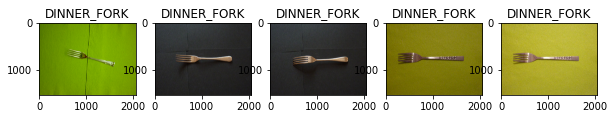

In [39]:
print('Первые 5 изображений датасета:')
draw_pictures(df[:5])

Изображения экземпляров разных классов:


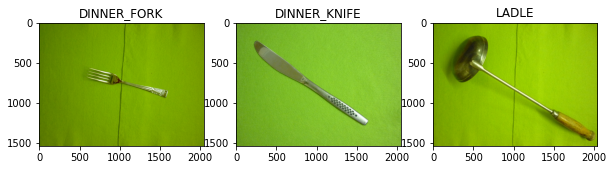

In [41]:
print('Изображения экземпляров разных классов:')
draw_pictures(df.groupby('img_class').min())

## Описательный анализ данных

### Описание численных типов данных

In [43]:
df.describe()

,height,width,dimension,max_rgb,min_rgb,mean_rgb,std_rgb,median_rgb
count,165.000000,165.000000,165.0,165.000000,165.000000,165.000000,165.000000,165.000000
mean,1743.521212,2039.848485,3.0,253.666672,0.557576,100.906487,55.192509,108.993942
std,1024.840699,933.187519,0.0,6.158806,3.643155,38.473503,14.540294,50.108360
min,102.000000,179.000000,3.0,208.000000,0.000000,29.022882,20.020618,17.000000
25%,1536.000000,2048.000000,3.0,255.000000,0.000000,82.371704,52.018585,61.000000
50%,1536.000000,2048.000000,3.0,255.000000,0.000000,99.149979,58.357685,117.000000
75%,1536.000000,2048.000000,3.0,255.000000,0.000000,115.260773,66.589523,138.000000
max,4128.000000,4128.000000,3.0,255.000000,37.000000,246.682693,82.704468,255.000000


#### Визуализация численных данных

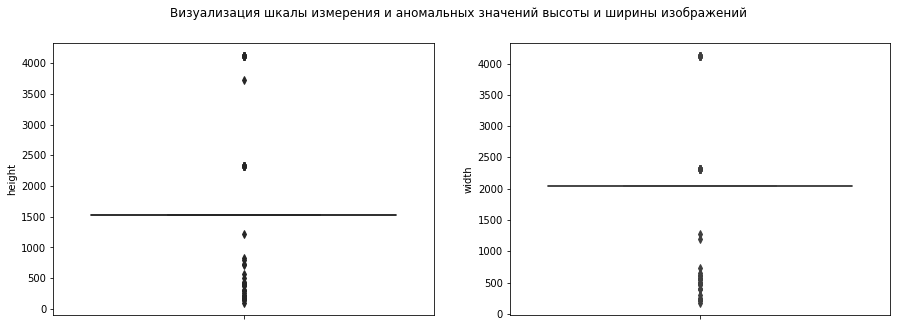

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация шкалы измерения и аномальных значений высоты и ширины изображений')
sns.boxplot(ax=axes[0], y="height", data=df, color='green')
sns.boxplot(ax=axes[1], y="width", data=df)
plt.show()

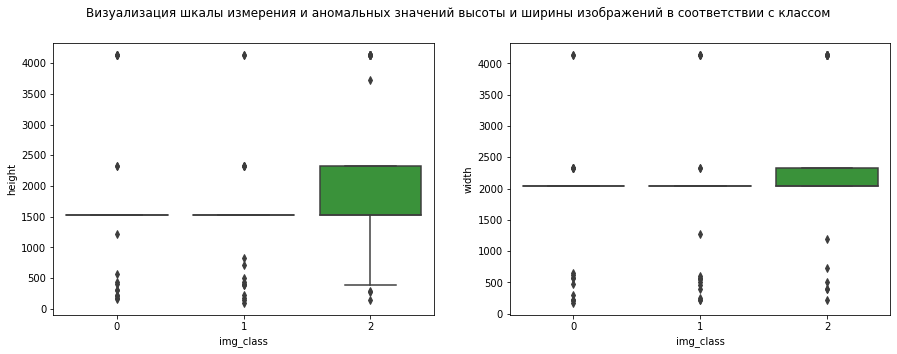

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация шкалы измерения и аномальных значений высоты и ширины изображений в соответствии с классом')
sns.boxplot(ax=axes[0], x="img_class", y="height", data=df)
sns.boxplot(ax=axes[1], x="img_class", y="width", data=df)
plt.show()

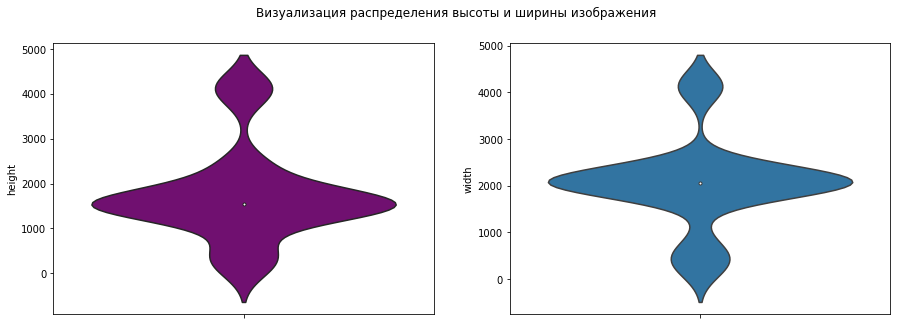

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Визуализация распределения высоты и ширины изображения ')
sns.violinplot(ax=axes[0], y = df['height'], color='purple')
sns.violinplot(ax=axes[1], y = df['width'])
plt.show()

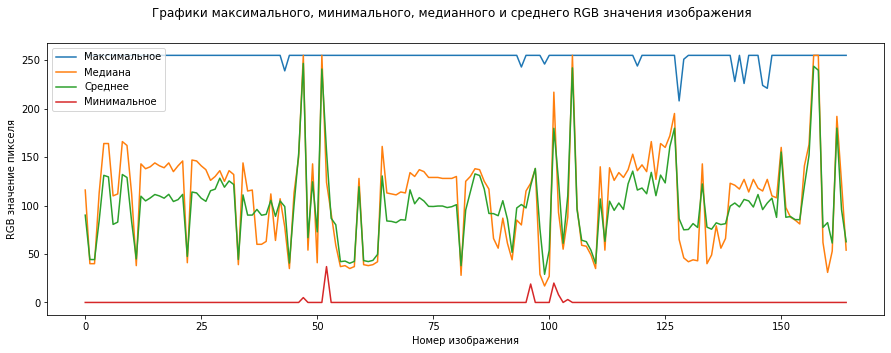

In [47]:
f, ax = plt.subplots(figsize=(15, 5))
f.suptitle('Графики максимального, минимального, медианного и среднего RGB значения изображения')
sns.lineplot(label='Максимальное', data=df['max_rgb'])
sns.lineplot(label='Медиана', data=df['median_rgb'])
sns.lineplot(label='Среднее', data=df['mean_rgb'])
sns.lineplot(label='Минимальное', data=df['min_rgb'])
plt.legend(fontsize=10, loc='upper left')
plt.xlabel('Номер изображения')
plt.ylabel('RGB значение пикселя')
plt.show()

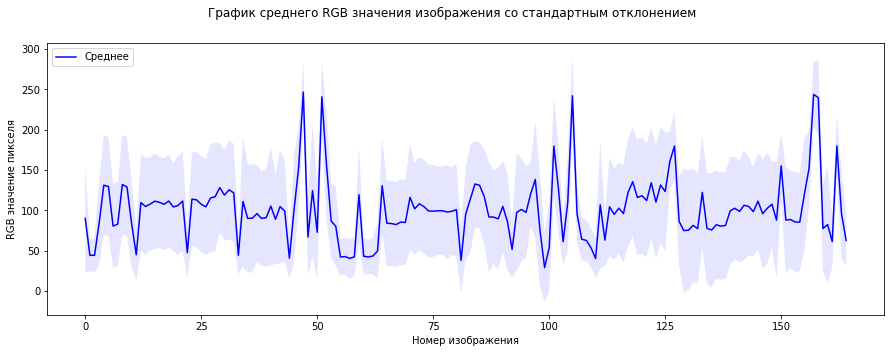

In [48]:
f, ax = plt.subplots(figsize=(15, 5))
f.suptitle('График среднего RGB значения изображения со стандартным отклонением')
sns.lineplot(label='Среднее', data=df['mean_rgb'], color='blue')
plt.fill_between(df.index, df['mean_rgb'] - df['std_rgb'], df['mean_rgb'] + df['std_rgb'], edgecolor='none',
                    facecolor='blue', alpha=0.1)
plt.legend(fontsize=10, loc='upper left')
plt.xlabel('Номер изображения')
plt.ylabel('RGB значение пикселя')
plt.show()


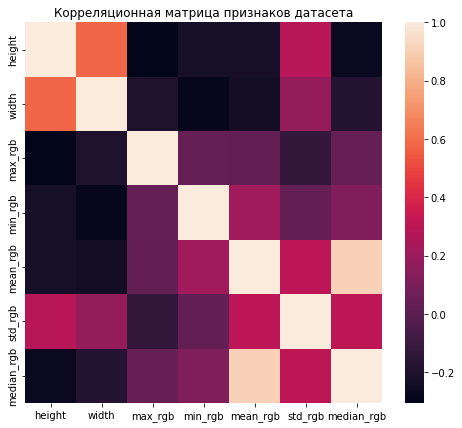

In [ ]:
plt.rcParams['figure.figsize'] = (8,7)
plt.title("Корреляционная матрица признаков датасета")
sns.heatmap(df.drop('dimension', axis=1).corr())
plt.show()

### Описание категориальных типов данных

In [49]:
df.describe(include = ['O'])

,img_class,img_label,path
count,165,165,165
unique,3,3,165
top,0,DINNER_FORK,../data/Raw/DINNER_FORK\dinnerforkraw1.JPG
freq,59,59,1


Распределение данных внутри датасета

In [50]:
for class_title, class_number in classes_dict.items():
    print (f"Класс номер {class_number} {class_title}: {len(df[df['img_class'] == str(class_number)])} ({len(df[df['img_class'] == str(class_number)])/len(df)*100:.2f}%)")
print (f"Всего: {len(df)}")

Класс номер 0 dinner_fork: 59 (35.76%)
Класс номер 1 dinner_knife: 52 (31.52%)
Класс номер 2 ladle: 54 (32.73%)
Всего: 165


### Цветовые гистограммы по трём каналам

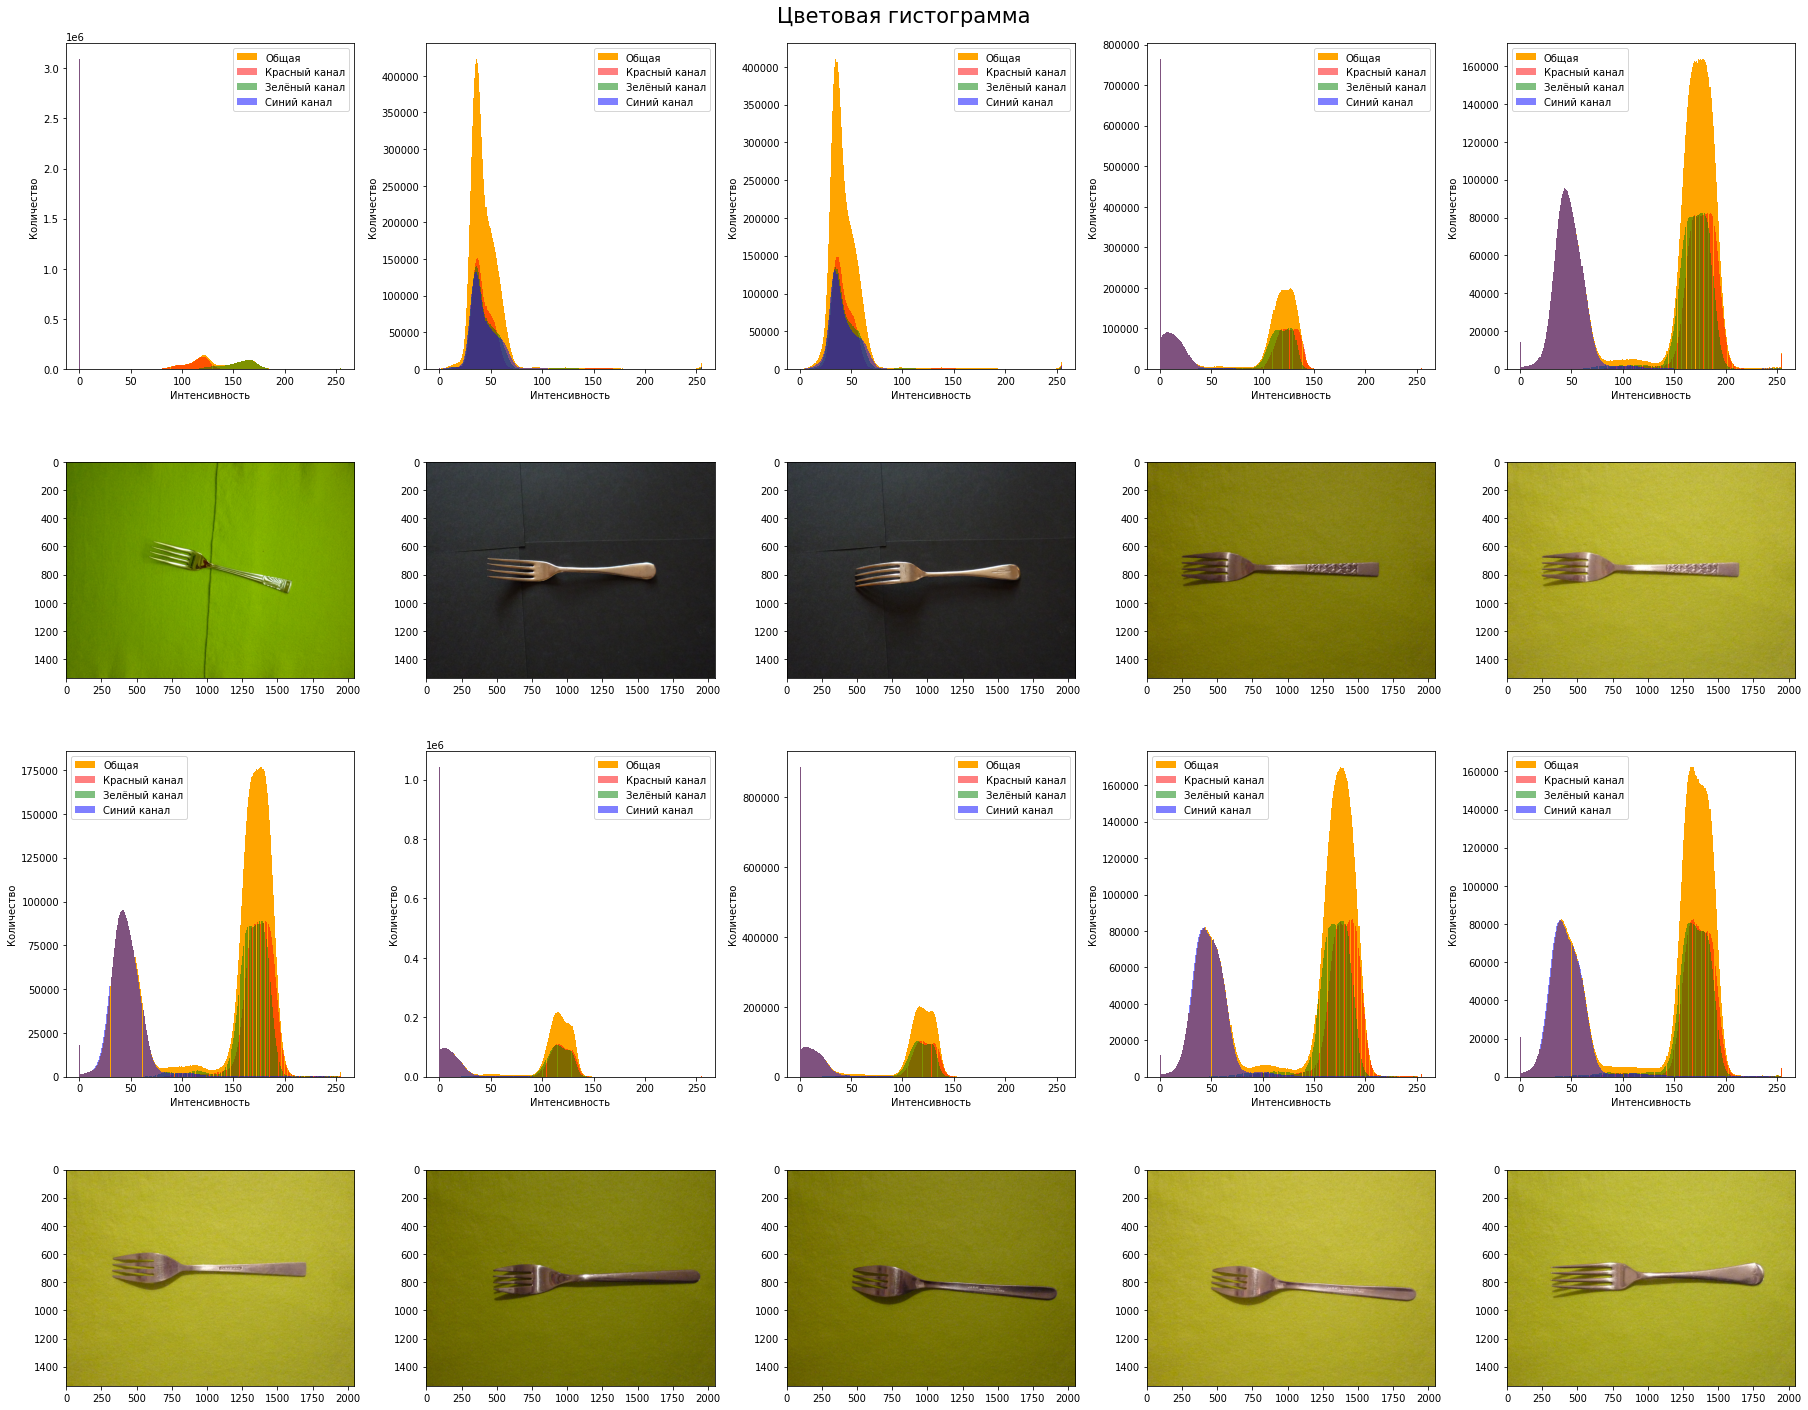

In [61]:
draw_pictures_with_hists(df[:10])

## Предобработка данных

### Добавление экземпляров

Функция изменения размера датасета до определенного количества экземпляров каждого класса 

In [67]:
def balance_data_size(train_generator, max_items=100):
    working_dir = os.path.join(os.path.relpath(
        os.path.join(train_generator.directory, "../")), 'Work')
    if os.path.isdir(working_dir):
        shutil.rmtree(working_dir)
    os.mkdir(working_dir)
    labels, counts = np.unique(train_generator.labels, return_counts=True)
    img_size = train_generator.target_size
    batch_size = train_generator.batch_size
    rotation = 45
    datagen = ImageDataGenerator(rotation_range=rotation,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.1,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode="nearest",
                                 validation_split=0.2
                                 )

    for label in train_generator.class_indices.keys():
        items_count = counts[np.where(
            labels == train_generator.class_indices[label])[0][0]]
        start_items = max_items
        if items_count < max_items:
            os.mkdir(os.path.join(working_dir, label))
            datagen_new = datagen.flow_from_directory(train_generator.directory,
                                                      subset='training',
                                                      batch_size=1,
                                                      seed=SEED,
                                                      class_mode='categorical',
                                                      save_to_dir=os.path.join(
                                                          working_dir, label),
                                                      classes=[label],
                                                      save_prefix=f"new_{label}",
                                                      save_format="jpeg")

            for _ in range(max_items - items_count):
                next(datagen_new)
            start_items = items_count
            print(f"Добавлено {max_items - items_count} элеметов в класс {label}\n")
        files = list(map(lambda x: x if label == x.split(
            '\\')[0] else '', train_generator.filenames))
        files = [x for x in files if x]
        for i in range(start_items):
            shutil.copy(os.path.join(
                train_generator.directory, files[i]),
                os.path.join(working_dir, label))

    train_generator = ImageDataGenerator().flow_from_directory(working_dir,
                                                               target_size=img_size,
                                                               batch_size=batch_size,
                                                               shuffle=False,
                                                               class_mode='categorical',
                                                               color_mode='rgb')

    return train_generator, working_dir


Процедура добавления изменённых экземпляров

In [10]:
def add_data_transformed(image_path, classes_dict, max_add_items): 
    rotation = 45
    datagen = ImageDataGenerator(rotation_range=rotation, 
                                width_shift_range=0.2, 
                                height_shift_range=0.2, 
                                shear_range=0.1, 
                                zoom_range=0.2, 
                                horizontal_flip=True, 
                                vertical_flip=True, 
                                fill_mode="nearest"
                                )
    for label in classes_dict.keys():
        datagen_new = datagen.flow_from_directory(image_path,
                                        batch_size=1,
                                        seed=SEED,
                                        class_mode='categorical',
                                        save_to_dir=image_path + label,
                                        classes=[label],
                                        save_prefix=f"added_{label}",
                                        save_format="jpeg")

        if max_add_items is None:
            max_add_items = len(datagen_new)*round((360/rotation))
        for _ in range(max_add_items):
            next(datagen_new)


Расширение датасета 

In [11]:
add_data_transformed( "../data/Raw/", classes_dict, 20)

Found 59 images belonging to 1 classes.
Found 52 images belonging to 1 classes.
Found 54 images belonging to 1 classes.


### Обработка и разделение данных 

In [65]:
img_size = (128,128)
batch_size = 128
datagen = ImageDataGenerator(
    rescale=1. / 255., 
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=0.2)
train_generator = datagen.flow_from_directory(IMAGE_PATH, 
                                    subset='training',
                                    target_size=img_size, 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')
test_generator = datagen.flow_from_directory(IMAGE_PATH, 
                                    subset='validation',
                                    target_size=img_size, 
                                    batch_size=batch_size, 
                                    shuffle=False, 
                                    class_mode='categorical', 
                                    color_mode='rgb')
classes_number = train_generator.num_classes

Found 182 images belonging to 3 classes.
Found 43 images belonging to 3 classes.


Балансировка количества экземпляров в каждом классе обучающей выборки

In [68]:
train_generator, working_dir = balance_data_size(train_generator, 200)

Found 64 images belonging to 1 classes.
Добавлено 136 элеметов в класс DINNER_FORK

Found 58 images belonging to 1 classes.
Добавлено 142 элеметов в класс DINNER_KNIFE

Found 60 images belonging to 1 classes.
Добавлено 140 элеметов в класс LADLE

Found 600 images belonging to 3 classes.


Разделение на обучающую и валидационную выборки

In [69]:
train_df = pd.DataFrame(data={'path':train_generator.filepaths, 'label': list(map(lambda x: x.split('\\')[0], train_generator.filenames))})
train_df, valid_df=train_test_split(train_df, train_size=0.8, shuffle=True, random_state=SEED, stratify=train_df['label'])
train_generator = datagen.flow_from_dataframe(train_df,
                                              x_col='path',
                                              y_col='label',
                                              target_size=img_size,
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False,
                                              color_mode='rgb')
valididation_generator = datagen.flow_from_dataframe(valid_df,
                                              x_col='path',
                                              y_col='label',
                                              target_size=img_size,
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False,
                                              color_mode='rgb')

Found 480 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.


Пример изображения и его гистограммы после обработки

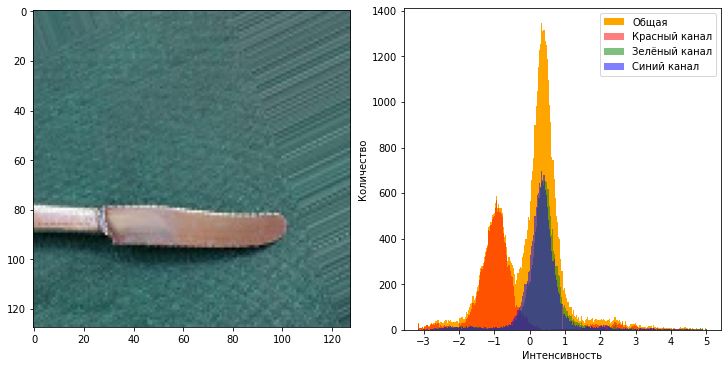

In [83]:
draw_image_with_hist(valididation_generator[0][0][0])

## Моделирование

### Функции визуализации

Отрисовка матрицы неточностей

In [152]:
def draw_heat(y_test, y_pred):
    class_names = y_test
    fig, ax = plt.subplots(figsize=(10, 8)) 
    plt.title('Матрица неточностей')
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)
    sns.heatmap(pd.DataFrame(
        metrics.confusion_matrix(y_test, y_pred)),
        annot=True)
    plt.ylabel('Действительные значения')
    plt.xlabel('Предсказанные значения')


In [170]:
def print_report(y_test, y_pred, classes_dict):
    classes=list(classes_dict.keys())
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(metrics.confusion_matrix(y_test, y_pred ), annot=True, vmin=0, fmt='g', cmap='RdPu', cbar=True)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90)
    plt.yticks(np.arange(length)+.5, classes, rotation=0)
    plt.xlabel("Предсказанные значения")
    plt.ylabel("Действительные значения")
    plt.title("Матрица неточностей")
    plt.show()
    class_rep = classification_report(y_test, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", class_rep)

Отрисовка графика с ошибкой

In [148]:
def plot_with_err(x, data, **kwargs):
    data_mean, data_std = data.mean(axis=1), data.std(axis=1)
    lines = plt.plot(x, data_mean, '-', **kwargs)
    plt.fill_between(x, data_mean - data_std, data_mean + data_std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)


Отрисовка обучающих кривых

In [187]:
def print_learning_curve(model, x, y):
    train_sizes = np.linspace(0.1, 1, 20)
    kfold = RepeatedKFold(n_splits=5, n_repeats=1,  random_state=SEED)
    _, train_scores, val_scores = learning_curve(
        model, x, y, train_sizes=train_sizes, cv=kfold)
    plt.figure('Learning Curve')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plot_with_err(train_sizes, train_scores,
                  label='Training scores', color='red')
    plot_with_err(train_sizes, val_scores,
                  label='Validation scores', color='green')
    plt.legend()
    plt.show()


### Преобразование генераторов в плоские массивы

In [196]:
y_test = test_generator.classes
y_train = np.asarray(train_generator.classes)
y_valid = np.asarray(valididation_generator.classes)
x_test = np.concatenate([test_generator.next()[0] for _ in range(test_generator.__len__())])
x_test = x_test.flatten().reshape(y_test.shape[0], -1)
x_train = np.concatenate([train_generator.next()[0] for _ in range(train_generator.__len__())])
x_train = x_train.flatten().reshape(y_train.shape[0], -1)
x_valid = np.concatenate([valididation_generator.next()[0] for _ in range(valididation_generator.__len__())])
x_valid = x_valid.flatten().reshape(y_valid.shape[0], -1)
x_train = np.vstack([x_train, x_valid])
y_train = np.hstack([y_train, y_valid])

Нормализация данных

In [197]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)
x_scaled = np.vstack([x_train_scaled, x_test_scaled])
y = np.hstack([y_train, y_test])

### Логистическая регрессия 

In [156]:
parameters = [{'solver': ['lbfgs', 'sag', 'saga']},
              {'penalty':['none', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1]}]
kfold = RepeatedKFold(n_splits=5, n_repeats=1,  random_state=SEED)
logreg = LogisticRegression()
grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = kfold,
                           verbose=0)

grid_result = grid_search.fit(x_train_scaled, y_train)
print(f"Best: {grid_result.best_score_} using { grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}") 

e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\utils\optimize.py:203:

Best: 0.5584798534798535 using {'solver': 'saga'}
0.506740 (0.025037) with: {'solver': 'newton-cg'}
0.514396 (0.031249) with: {'solver': 'lbfgs'}
0.518223 (0.038660) with: {'solver': 'liblinear'}
0.550751 (0.034589) with: {'solver': 'sag'}
0.558480 (0.037994) with: {'solver': 'saga'}
0.512436 (0.024614) with: {'penalty': 'none'}
nan (nan) with: {'penalty': 'elasticnet'}
nan (nan) with: {'penalty': 'l1'}
0.514396 (0.031249) with: {'penalty': 'l2'}
0.531740 (0.055887) with: {'C': 0.001}
0.550842 (0.049071) with: {'C': 0.01}
0.520128 (0.030087) with: {'C': 0.1}
0.514396 (0.031249) with: {'C': 1}
0.502821 (0.032578) with: {'C': 10}
0.529652 (0.025636) with: {'C': 100}


In [198]:
logreg = LogisticRegression(C=0.01, solver='saga')
y_pred_logreg = cross_val_predict(logreg, x_scaled, y, cv=kfold)

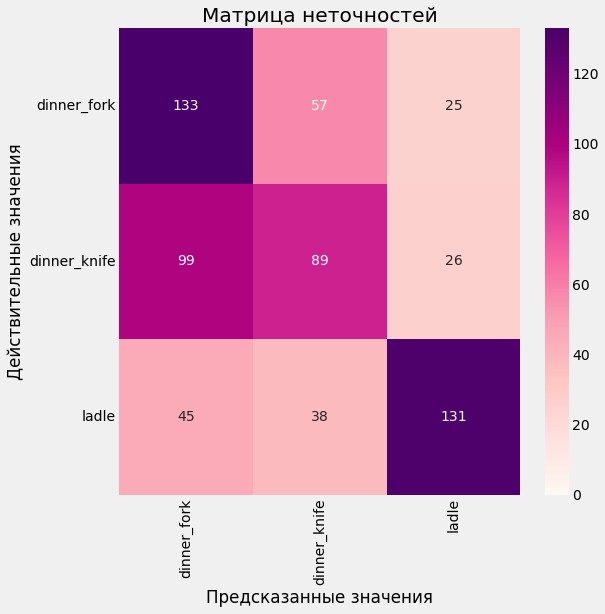

Classification Report:
----------------------
               precision    recall  f1-score   support

 dinner_fork       0.48      0.62      0.54       215
dinner_knife       0.48      0.42      0.45       214
       ladle       0.72      0.61      0.66       214

    accuracy                           0.55       643
   macro avg       0.56      0.55      0.55       643
weighted avg       0.56      0.55      0.55       643



In [199]:
print_report(y, y_pred_logreg, classes_dict)

Обучающие кривые

In [200]:
print_learning_curve(logreg, x_scaled, y)

### Метод опорных векторов 

In [ ]:
parameters = [{'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]
kfold = RepeatedKFold(n_splits=5, n_repeats=1,  random_state=SEED)
svc = svm.SVC()
grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = kfold,
                           verbose=0)

grid_result = grid_search.fit(x_train_scaled, y_train)

print(f"Best: {grid_result.best_score_} using { grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}") 

In [ ]:
svc = svm.SVC()
y_pred_svc = cross_val_predict(logreg, x_scaled, y, cv=kfold)

In [ ]:
print_report(y, y_pred_svc, classes_dict)

e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: Co

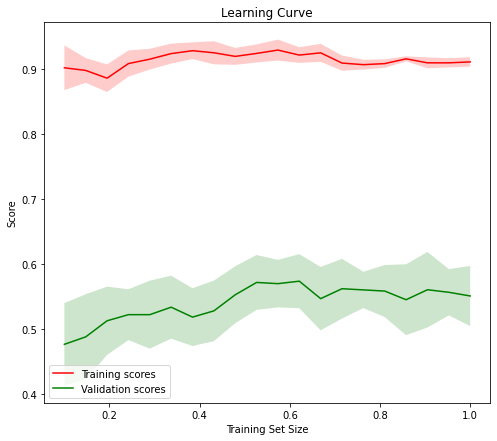

In [ ]:
print_learning_curve(svc, x_scaled, y)

### Метод k ближайших соседей 

In [ ]:
parameters = [{'n_neighbors': list(range(1, 20)), 'weights': ['uniform', 'distance']}]
kfold = RepeatedKFold(n_splits=5, n_repeats=1,  random_state=SEED)
kneighbors = KNeighborsClassifier()
grid_search = GridSearchCV(estimator = kneighbors,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = kfold,
                           verbose=0)

grid_result = grid_search.fit(x_train_scaled, y_train)

print(f"Best: {grid_result.best_score_} using { grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}") 

In [ ]:
kneighbors = KNeighborsClassifier()
y_pred_kneighbors = cross_val_predict(kneighbors, x_scaled, y, cv=kfold)

In [ ]:
print_report(y, y_pred_kneighbors, classes_dict)

e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
e:\ДЗ\Курсовая 6 сем\venv\lib\site-packages\sklearn\linear_model\_sag.py:354: Co

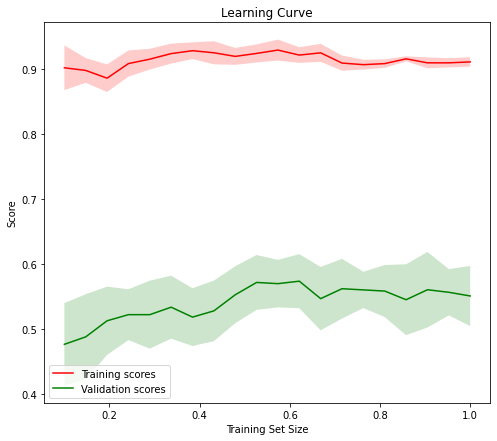

In [ ]:
print_learning_curve(kneighbors, x_scaled, y)

### Свёрточная нейросеть

#### Grid search

In [ ]:
def create_model(neurons):
    model = Sequential()
    model.add(Conv2D(neurons, (3, 3),
              input_shape=train_generator[0][0].shape[1:], padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))  # new 933
    model.add(MaxPooling2D(pool_size=(2, 2)))  # new
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(8, kernel_constraint=maxnorm(3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(classes_number))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
model = KerasClassifier(model=create_model, neurons=2, verbose=0)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [5, 10, 20, 25]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
neurons = [2, 4, 8, 16, 32, 64, 128]
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

param_grid = dict(neurons=neurons)
grid = GridSearchCV(model, param_grid=param_grid, cv=kfold)
grid_result = grid.fit(x_train_scaled, y_train, epochs=50, batch_size=40)

print(f"Best: {grid_result.best_score_} using { grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}") 

Best: 0.155556 using {'neurons': 8}
0.096296 (0.136184) with: {'neurons': 2}
0.074074 (0.104757) with: {'neurons': 4}
0.155556 (0.110368) with: {'neurons': 8}
0.081481 (0.073330) with: {'neurons': 16}
0.074074 (0.104757) with: {'neurons': 32}
0.111111 (0.079089) with: {'neurons': 64}
0.074074 (0.104757) with: {'neurons': 128}


#### Модель

In [177]:
#при 25 эпи 9630 78
epochs = 50
batch_size = 40
model = Sequential()
model.add(Conv2D(2, (3, 3), input_shape=train_generator[0][0].shape[1:], padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))#new 933
model.add(MaxPooling2D(pool_size=(2, 2)))#new 
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(8, kernel_constraint=maxnorm(3), activation='relu')) 
model.add(BatchNormalization())
model.add(Dense(classes_number))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [183]:
history = model.fit(test_generator, validation_data=valididation_generator, epochs=epochs, batch_size=batch_size)

Epoch 1/25
1/1 [==============================] - 4s 4s/step - loss: 0.2113 - accuracy: 1.0000 - val_loss: 1.3183 - val_accuracy: 0.3333
Epoch 2/25
1/1 [==============================] - 2s 2s/step - loss: 0.2071 - accuracy: 1.0000 - val_loss: 1.3004 - val_accuracy: 0.3250
Epoch 3/25
1/1 [==============================] - 2s 2s/step - loss: 0.2023 - accuracy: 1.0000 - val_loss: 1.2843 - val_accuracy: 0.3167
Epoch 4/25
1/1 [==============================] - 3s 3s/step - loss: 0.1970 - accuracy: 1.0000 - val_loss: 1.2697 - val_accuracy: 0.3333
Epoch 5/25
1/1 [==============================] - 2s 2s/step - loss: 0.1917 - accuracy: 1.0000 - val_loss: 1.2565 - val_accuracy: 0.3417
Epoch 6/25
1/1 [==============================] - 2s 2s/step - loss: 0.1867 - accuracy: 1.0000 - val_loss: 1.2440 - val_accuracy: 0.3417
Epoch 7/25
1/1 [==============================] - 2s 2s/step - loss: 0.1826 - accuracy: 1.0000 - val_loss: 1.2316 - val_accuracy: 0.3417
Epoch 8/25
1/1 [=========================

In [184]:
scores = model.evaluate(test_generator, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 81.40%


In [180]:
prediction = model.predict(test_generator)

In [ ]:
estimator= KerasClassifier(model=model, epochs=epochs, batch_size=batch_size, verbose=0)
kfold= RepeatedKFold(n_splits=5, n_repeats=1,  random_state=SEED)
prediction = cross_val_predict(estimator, x_train, y_train, cv=kfold)  

INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmp4f04hjr8\assets
INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmpfwzwyt_f\assets
INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmp7l6uppcy\assets
INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmp7bo2m29q\assets
INFO:tensorflow:Assets written to: C:\Users\Lisa\AppData\Local\Temp\tmp_3wh227_\assets


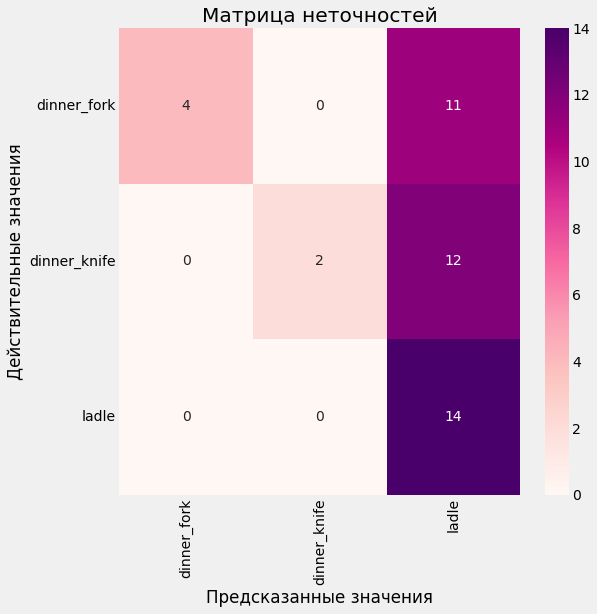

Classification Report:
----------------------
               precision    recall  f1-score   support

 dinner_fork       1.00      0.27      0.42        15
dinner_knife       1.00      0.14      0.25        14
       ladle       0.38      1.00      0.55        14

    accuracy                           0.47        43
   macro avg       0.79      0.47      0.41        43
weighted avg       0.80      0.47      0.41        43



In [182]:
print_report(test_generator.classes, prediction.argmax(axis=1), classes_dict)

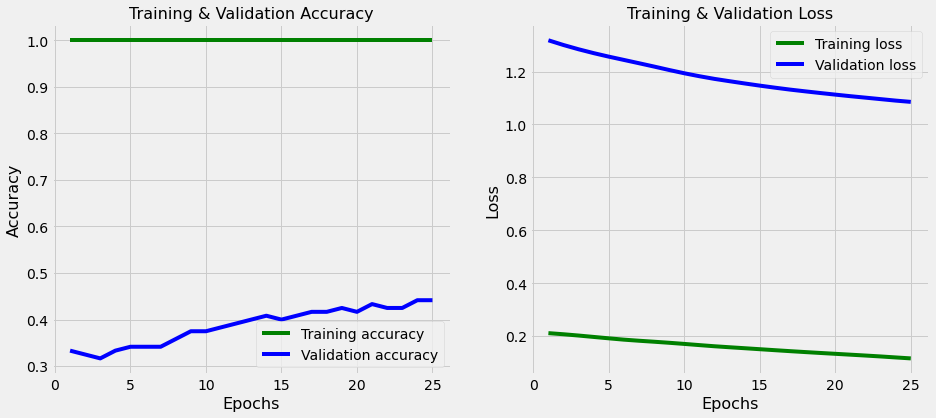

In [186]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(epochs, accuracy, 'g', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

ax[1].plot(epochs, loss_values, 'g', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()
plt.show()